# River

- Guillaume Philippe 
- Godefroy Du Chalard 

In [ ]:
%%shell
jupyter nbconvert --to html /content/data_stream_processing_lab_1.ipynb

[NbConvertApp] Converting notebook /content/data_stream_processing_lab_1.ipynb to html
[NbConvertApp] Writing 511191 bytes to /content/data_stream_processing_lab_1.html


In [ ]:
!pip install river

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


`River` is an open-source machine learning library for data streams. It is being developed by  **Télécom ParisTech**, **École Polytechique**, and the **University of Waikato**.

In this lab we will use `River`. Visit the page of the [library](https://riverml.xyz/) and follow the [installation instructions](https://riverml.xyz/latest/getting-started/installation/).

**Notice:** `River` requires `NumPy` and `Cython`
Also, for this lab you will need: `scikit-learn`, `pandas`, and `matplotlib`.

# Classification in Data Streams

The goal of this lab is to build a classifier capable of learning and making predictions in a datastream using the `River` library. In this lab we are comparing three datastream classifiers on Electricity dataset:
- kNN
- Hoeffding Tree
- Batch-Incremental Ensemble Classifier (BIE)

The last of the three classifiers is not implemented yet. This is the task of this lab. You should implement the `learn_one` and `predict_one` methods in the `BatchClassifier` class. 

Tasks:
1. Implement a tumbling window of size 100, creating and maintaining up to a maximum of 100 models. 
2. Build a batch `DecisionTreeClassifier` on each of the batches/windows.

**Note:** The Decision Tree is a batch model that takes as input `np.array`. You can convert dictionaries (default data type in `River`) into `np.array` with the utility method `dict2numpy` available in `river.utils` 

In [ ]:
from os import XATTR_SIZE_MAX
from sklearn.tree import DecisionTreeClassifier
from river.utils import dict2numpy
from collections import Counter
import numpy as np

class BatchClassifier:

    def __init__(self, window_size=100, max_models=100):
        self.H = []
        self.h = None
        # TODO
        self.max_models = max_models
        self.window_size = window_size
        self.window_x = []
        self.window_y = []

    def learn_one(self, x, y=None):
        self.window_x.append(dict2numpy(x))
        self.window_y.append(y)
        if len(self.window_x) < self.window_size:
          return self
        # TODO
        batch_x = np.stack(self.window_x)
        batch_y = np.stack(self.window_y)
        if len(self.H) >= 100:
          self.H.pop(0)
        # HINT: You can build a decision tree model on a set of data like this:
        h = DecisionTreeClassifier()
        h.fit(batch_x, batch_y)
        self.H.append(h) # <-- and append it to the ensemble

        self.window_x = []
        self.window_y = []
        return self

    def predict_one(self, x):
        # TODO
        # Be mindful of the case when the model is still empty and predictions are requested.
        # The best practice is to return a default value.
        if len(self.H) < self.max_models:
          return 0
        x = dict2numpy(x)
        x = x.reshape(1, -1)
        preds = [h.predict(x) for h in self.H]
        return  Counter(np.stack(preds).squeeze()).most_common(1)[0][0]

## Evaluation

Here we provide auxiliary functions and setup the evaluation. The `evaluate` method implements the test-then-train evaluation and tracks performance using `accuracy` and `kappa`. For each metric, two values are calculated: **prequential** (or rolling) indicates the performance of the model over a sliding window and **test-then-train** represents the performance of the model over *all* seen data from the stream. The method returns a dataframe with the results for the test calculated every `n_wait` samples (metrics are updated on every new sample). These results are used to plot performance later in the notebook.

**Note:** You do not need to modify the code in the following cell.

In [ ]:
from river.tree import HoeffdingTreeClassifier
from river.neighbors import KNNClassifier
from river.stream import iter_pandas
from river import metrics, utils

import pandas as pd

dataset = "elec"

def print_progress(sample_id, acc, kappa):
    print(f'Samples processed: {sample_id}')
    print(acc)
    print(kappa)

def evaluate(stream, model, n_wait=1000, verbose=False):
    acc = metrics.Accuracy()
    acc_rolling = utils.Rolling(metrics.Accuracy(), window_size=n_wait)
    kappa = metrics.CohenKappa()
    kappa_rolling = utils.Rolling(metrics.CohenKappa(), window_size=n_wait)
    raw_results = []
    model_name = model.__class__.__name__
    for i, (x, y) in enumerate(stream):
        # Predict
        y_pred = model.predict_one(x)
        # Update metrics and results
        acc.update(y_true=y, y_pred=y_pred)
        acc_rolling.update(y_true=y, y_pred=y_pred)
        kappa.update(y_true=y, y_pred=y_pred)
        kappa_rolling.update(y_true=y, y_pred=y_pred)
        if i % n_wait == 0 and i > 0:
            if verbose:
                print_progress(i, acc, kappa)
            raw_results.append([model_name, i, acc.get(), acc_rolling.get(), kappa.get(), kappa_rolling.get()])
        # Learn (train)
        model.learn_one(x, y)
    print_progress(i, acc, kappa)
    return pd.DataFrame(raw_results, columns=['model', 'id', 'acc', 'acc_roll', 'kappa', 'kappa_roll'])

# Load the data, will be transformed into a stream later
df = pd.read_csv("./data/"+dataset+".csv")
label_col = df.columns[-1]
feature_cols = list(df.columns)
feature_cols.pop()
X = df[feature_cols]
Y = df[label_col]

# Initialize models
knn = KNNClassifier(n_neighbors=10, window_size=100)
ht = HoeffdingTreeClassifier()
bie = BatchClassifier(window_size=100, max_models=100)

#### Extra points

Modify the evaluation to report training and testing time. Modify the plotting code accordingly to report processing time as well.

### Run experiments

Note that we convert the stream (`iter_pandas`) on each call to `evaluate`, this ensures that we are passing the stream properly initialized.

In [ ]:
knn_results = evaluate(stream=iter_pandas(X=X, y=Y),
                       model=knn)

Samples processed: 45310
Accuracy: 80.32%
CohenKappa: 59.58%


In [ ]:
ht_results = evaluate(stream=iter_pandas(X=X, y=Y),
                      model=ht)

Samples processed: 45310
Accuracy: 77.85%
CohenKappa: 54.00%


In [ ]:
bie_results = evaluate(stream=iter_pandas(X=X, y=Y),
                      model=bie)

Samples processed: 45310
Accuracy: 69.80%
CohenKappa: 35.38%


## Generate plots

The code below uses the raw results from the `evaluate` method to generate the plots for `accuracy` and `kappa` and generates a `pdf` file. 

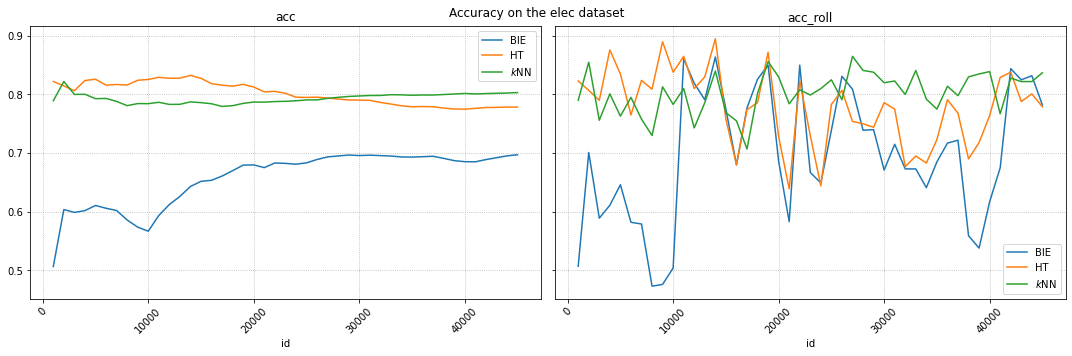

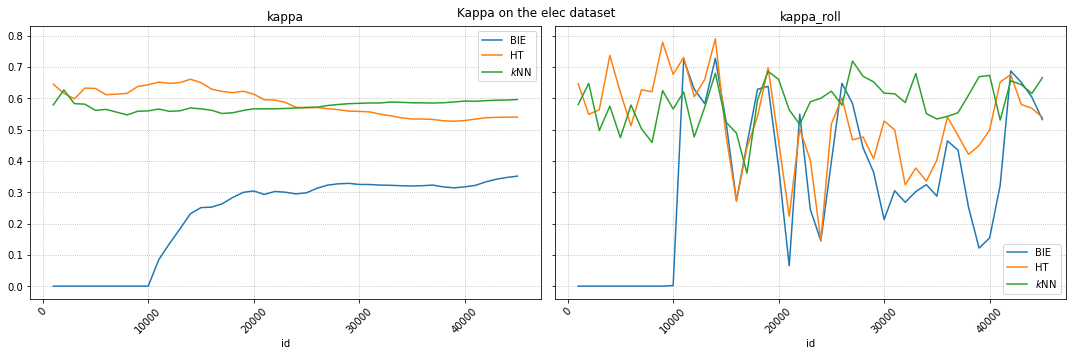

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

dataset = "elec"

df = pd.concat([knn_results, ht_results, bie_results])
df.set_index('id', inplace=True)
grouped = df.groupby('model')

# accuracy
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharey=True)
for metric, ax in zip(['acc', 'acc_roll'], axes.flatten()):
    grouped[metric].plot(rot=45, title=metric, legend=True, ax=ax)
    ax.legend(["BIE", "HT", r"$k$NN"], loc='best')
    ax.grid(linestyle=':')
fig.suptitle("Accuracy on the %s dataset" % dataset)
plt.tight_layout()

# kappa
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharey=True)
for metric, ax in zip(['kappa', 'kappa_roll'], axes.flatten()):
    grouped[metric].plot(rot=45, title=metric, legend=True, ax=ax)
    ax.legend(["BIE", "HT", r"$k$NN"], loc='best')
    ax.grid(linestyle=':')
fig.suptitle("Kappa on the %s dataset" % dataset)
plt.tight_layout()


**Remarks** :
- KNN and HoeffdingTree are almost stable in the time for Kappa and Accuracy. It's logic because more terms we have in the computation, more it's difficult to change the metric value.
- Our model, BatchClassifier, performs worse than the other 2 methods.
- We can't see it on this plot, but our BatchClassifier is slow compared to the other methods.
- For rolling metrics, they aren't stable in time.
- BatchClassifier and HoeffdingTree rolling metrics are almost correlated, they vary in the same way.

## Deliverables

You should submit:
1. The Jupyter Notebook 
2. `html` version of notebook (go to: `File/Download as/HTML`), with visible outputs of your code

in a compressed file (`.zip`, `.rar`, `tar.gz`...), and compressed file should be named: `firstname_lastname_lab2.zip`